In [1]:
import math
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [2]:
import session_info
session_info.show()

In [3]:
# Import dataset
df = pd.read_csv("Datasets/dataset (MSFT).csv")
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (7779, 7)


,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
0,2022-09-19 09:30:00-04:00,242.464996,242.479996,242.000000,242.136002,242.136002,677274.0
1,2022-09-19 09:31:00-04:00,242.190002,242.589996,242.100006,242.544998,242.544998,81735.0
2,2022-09-19 09:32:00-04:00,242.315002,242.519104,242.190094,242.464996,242.464996,178308.0
3,2022-09-19 09:33:00-04:00,242.479996,242.615005,242.229996,242.399994,242.399994,22108.0
4,2022-09-19 09:34:00-04:00,242.169998,242.589798,242.169998,242.361206,242.361206,148771.0


In [4]:
# Import model
keras.models.load_model

model = tf.saved_model.load('Models/11-29-2022')

In [5]:
# Train test split
# 1: Open, 2: High, 3: Low, 4: Close
training_set = df.iloc[:5446, 1:5].values
test_set = df.iloc[5446:, 1:5].values

print(training_set.shape)
print(test_set.shape)

(5446, 4)
(2333, 4)


In [6]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# print(training_set_scaled.shape)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 5446):
    X_train.append(training_set_scaled[i-60:i, 0:4])
    y_train.append(training_set_scaled[i, 0:4])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
#(840, 60, 1)
X_train.shape

(5386, 60, 4)

In [14]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 4)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 4))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
169/169 [==============================] - 33s 144ms/step - loss: 0.0169
Epoch 2/100
169/169 [==============================] - 25s 149ms/step - loss: 0.0064
Epoch 3/100
169/169 [==============================] - 26s 155ms/step - loss: 0.0053
Epoch 4/100
169/169 [==============================] - 29s 170ms/step - loss: 0.0042
Epoch 5/100
169/169 [==============================] - 27s 159ms/step - loss: 0.0041
Epoch 6/100
169/169 [==============================] - 25s 149ms/step - loss: 0.0033
Epoch 7/100
169/169 [==============================] - 25s 150ms/step - loss: 0.0030
Epoch 8/100
169/169 [==============================] - 26s 154ms/step - loss: 0.0029
Epoch 9/100
169/169 [==============================] - 25s 150ms/step - loss: 0.0025
Epoch 10/100
169/169 [==============================] - 26s 153ms/step - loss: 0.0023
Epoch 11/100
169/169 [==============================] - 25s 150ms/step - loss: 0.0022
Epoch 12/100
169/169 [==============================] - 26s 155

In [55]:
# Save the model
model.save('Models/11-29-2022')

AttributeError: '_UserObject' object has no attribute 'save'

In [7]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:5446, 1:5]
dataset_test = df.iloc[5446:, 1:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,4)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 2393):
    X_test.append(inputs[i-60:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))
print(X_test.shape)
# (300, 60, 1)
X_test.shape

(2333, 60, 4)


(2333, 60, 4)

In [8]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape

AttributeError: '_UserObject' object has no attribute 'predict'

In [9]:
predicted_stock_price[0: , 0].shape

NameError: name 'predicted_stock_price' is not defined

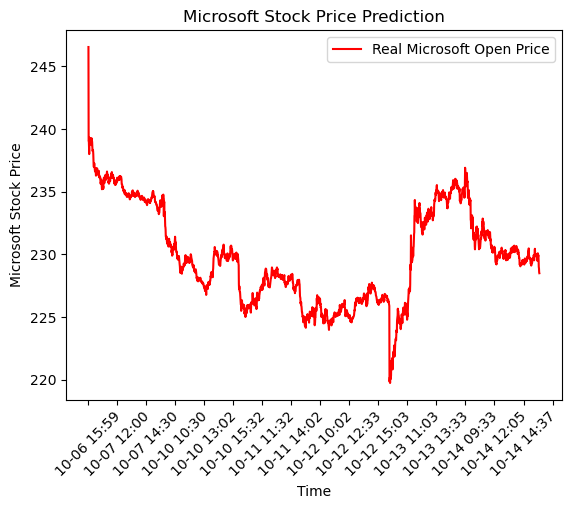

In [10]:
# Visualising the results
dfloc = df.loc[5446:, 'Unnamed: 0']

plt.plot(dfloc.str[5:16],dataset_test.Open.values, color = 'red', label = 'Real Microsoft Open Price')
#plt.plot(dfloc.str[5:16],predicted_stock_price[0: , 0], color = 'blue', label = 'Predicted Microsoft Open Price')

plt.xticks(np.arange(0,2500,150), rotation=45)
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.show()

In [94]:
# Download predicted values into csv
predicted_prices_df = pd.DataFrame(predicted_stock_price, columns = ['Open','High','Low', 'Close'])
predicted_prices_df.to_csv (r'C:\Users\kayra\OneDrive\Desktop\Stonks 2022\Stocks-Prediction\Predictions\Combined Model Price Prediction.csv', index = False, header=True)